In [1]:
!pip install seaborn
!pip install ipywidgets

  Using cached seaborn-0.11.1-py3-none-any.whl (285 kB)
  Using cached ipywidgets-7.6.3-py2.py3-none-any.whl (121 kB)
  Using cached jupyterlab_widgets-1.0.0-py3-none-any.whl (243 kB)
  Using cached nbformat-5.1.2-py3-none-any.whl (113 kB)
  Using cached widgetsnbextension-3.5.1-py2.py3-none-any.whl (2.2 MB)
  Using cached jsonschema-3.2.0-py2.py3-none-any.whl (56 kB)
  Using cached pyrsistent-0.17.3-cp36-cp36m-linux_x86_64.whl
  Using cached notebook-6.2.0-py3-none-any.whl (9.5 MB)
  Using cached argon2_cffi-20.1.0-cp35-abi3-manylinux1_x86_64.whl (97 kB)
  Using cached nbconvert-6.0.7-py3-none-any.whl (552 kB)
  Using cached Send2Trash-1.5.0-py3-none-any.whl (12 kB)
  Using cached terminado-0.9.2-py3-none-any.whl (14 kB)
  Using cached prometheus_client-0.9.0-py2.py3-none-any.whl (53 kB)
  Using cached jupyterlab_pygments-0.1.2-py2.py3-none-any.whl (4.6 kB)
  Using cached nbclient-0.5.2-py3-none-any.whl (65 kB)
  Using cached defusedxml-0.6.0-py2.py3-none-any.whl (23 kB)
  Using cache

In [ ]:
import os #working with local files
import time
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics

import torch
from torch import nn, cuda, optim, device
from torchvision import (models, #getting the pretrained resnet
                         transforms, 
                         datasets) 
from torch.utils.data import DataLoader
from PIL import Image

import boto3


In [ ]:
sorted_list_of_dirs = [i.title() for i in os.listdir('train')]
sorted_list_of_dirs.sort()

idx_to_class_label = {
    idx: class_label for idx, class_label in zip(range(len(sorted_list_of_dirs)), sorted_list_of_dirs)
}

with open('idx_to_class_label.json', 'w') as f:
    json.dump(idx_to_class_label, f)
    
with open('idx_to_class_label.json', 'rb') as f:
    j = json.load(f)


In [3]:
model = models.resnet50(pretrained=True)
for param in model.parameters():
    param.require_grad = False
    
model.fc = nn.Sequential(nn.Linear(model.fc.in_features, 1024),
                        nn.ReLU(),
                        nn.Dropout(0.30),
                        nn.Linear(1024, 250))


In [4]:
device = torch.device('cuda:0' if cuda.is_available() else 'cpu')

model.to(device)
print(device)


cuda:0


In [5]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(45),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

In [6]:
train_data = datasets.ImageFolder('train')
val_data = datasets.ImageFolder('valid')
test_data = datasets.ImageFolder('test')

train_data.transform = train_transform
val_data.transform = val_transform
test_data.transform = test_transform

batch_size=16

train_loader = DataLoader(train_data,
                         batch_size=batch_size,
                         shuffle=True)
val_loader = DataLoader(val_data,
                        batch_size=batch_size,
                        shuffle=True)
test_loader = DataLoader(test_data,
                        batch_size=batch_size,
                        shuffle=True)


In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),
                      lr=0.0001)

In [12]:
def fit(train_loader, val_loader, model, criterion, optimizer, num_epochs=10, batch_size=16):
    start = time.time()
    best_model = model.state_dict()
    best_acc = 0
    train_loss_over_time = []
    val_loss_over_time = []
    train_acc_over_time = []
    val_acc_over_time = []
    early_stop_min_increase = 0.0001
    early_stop_patience = 10
    epochs_no_improve = 0
    early_stop = False
    
    for epoch in range(num_epochs):
        print(f"Epoch number: {epoch+1}/{num_epochs}")
        
        for phase in ['train', 'val']:
            if phase=='train':
                data_loader = train_loader
                model.train()
            else:
                data_loader = val_loader
                model.eval()
                
            running_loss = 0
            running_corrects = 0
            
            for inputs, labels in data_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase=='train'):
                    outputs = model(inputs)
                    _, pred = torch.max(outputs, dim=1)
                    loss = criterion(outputs, labels)
                    
                    if phase=='train':
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(pred==labels.data)
                        
            if phase=='train':
                epoch_loss = running_loss/len(train_loader.dataset)
                train_loss_over_time.append(epoch_loss)
                epoch_acc = running_corrects.double()/len(train_loader.dataset)
                train_acc_over_time.append(epoch_acc)

            else:
                epoch_loss = running_loss/len(val_loader.dataset)
                val_loss_over_time.append(epoch_loss)
                epoch_acc = running_corrects.double()/len(val_loader.dataset)
                val_acc_over_time.append(epoch_acc)
                
                #early stopping
                #if the difference between this epoch valid acc and the previous epoch valid acc
                #isn't greater than the desired min increase, then the model is not improving
                #if the model is not improving for 5 epochs straight, early stop.
#                 if len(val_acc_over_time) >= 5:
# #                     prev_epoch_acc = val_acc_over_time[-2]
#                     recent_epoch_accs = val_acc_over_time[-5:-1]
#                     if epoch_acc - np.max(recent_epoch_accs) <= early_stop_min_increase:
# #                     if (epoch_acc - prev_epoch_acc) <= early_stop_min_increase:
#                         epochs_no_improve += 1
#                         print('Model has not improved beyond threshold')
#                     else:
#                         if epochs_no_improve:
#                             epochs_no_improve = 0
#                             print('Model has improved, resetting early stop count')
                    
            print(f"{phase} loss: {epoch_loss:.3f}, acc: {epoch_acc:.3f}")
                
            if phase=='val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = model.state_dict()
                torch.save(model, 'trained_model_resnet50_checkpoint.pt') #checkpoint
                epochs_no_improve = 0
            elif phase == 'val' and epoch_acc < best_acc:
                epochs_no_improve += 1
                print(f"Number of epochs without improvement has increased to {epochs_no_improve}")
        if epochs_no_improve >= early_stop_patience:
            early_stop = True
        if early_stop:
            print('Early stopping!')
            break
        print('-'*60)
    total_time = (time.time() - start)/60
    print(f"Training completed. Time taken: {total_time:.3f} min\nBest accuracy: {best_acc:.3f}")
    model.load_state_dict(best_model)
    loss = {'train': train_loss_over_time,
           'val': val_loss_over_time}
    acc = {'train': train_acc_over_time,
          'val': val_acc_over_time}
    return model, loss, acc


In [ ]:
history, loss, acc = fit(train_loader, val_loader, model, criterion, optimizer,
                        num_epochs=100, batch_size=batch_size)


Epoch number: 1/100
train loss: 0.225, acc: 0.933
val loss: 0.125, acc: 0.974
------------------------------------------------------------
Epoch number: 2/100
train loss: 0.205, acc: 0.938
val loss: 0.103, acc: 0.972
Number of epochs without improvement has increased to 1
------------------------------------------------------------
Epoch number: 3/100
train loss: 0.198, acc: 0.942
val loss: 0.111, acc: 0.963
Number of epochs without improvement has increased to 2
------------------------------------------------------------
Epoch number: 4/100
train loss: 0.181, acc: 0.945
val loss: 0.117, acc: 0.968
Number of epochs without improvement has increased to 3
------------------------------------------------------------
Epoch number: 5/100
train loss: 0.178, acc: 0.946
val loss: 0.109, acc: 0.974
------------------------------------------------------------
Epoch number: 6/100
train loss: 0.169, acc: 0.948
val loss: 0.113, acc: 0.970
Number of epochs without improvement has increased to 1
---

In [ ]:
def evaluate(test_loader, model, criterion):
    model.eval()
    test_loss = 0
    test_acc = 0
    preds = list()
    labels_list = list()
    
    for inputs, labels in test_loader:
        
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, pred = torch.max(outputs, dim=1)
            preds.append(pred)
            labels_list.append(labels)
            
        test_loss += loss.item()*inputs.size(0)
        correct = pred.eq(labels.data.view_as(pred))
        accuracy = torch.mean(correct.type(torch.FloatTensor))
        test_acc += accuracy.item() * inputs.size(0)
        
    test_loss = test_loss/len(test_loader.dataset)
    test_acc = test_acc / len(test_loader.dataset)
        
    print(f"Test loss: {test_loss:.4f}\nTest acc: {test_acc:.4f}")
    
    return preds, labels_list


In [ ]:
predictions, labels = evaluate(val_loader, model, criterion)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(np.array(torch.cat(labels)), np.array(torch.cat(predictions))))

In [28]:
np.array(torch.cat(labels)), np.array(torch.cat(predictions))

array([173,  96, 117, ..., 238, 160, 246])

In [30]:
f1_score = metrics.f1_score(np.array(torch.cat(labels)), np.array(torch.cat(predictions)), average='weighted')
acc = metrics.accuracy_score(np.array(torch.cat(labels)), np.array(torch.cat(predictions)))
recall = metrics.recall_score(np.array(torch.cat(labels)), np.array(torch.cat(predictions)), average='weighted')
precision = metrics.precision_score(np.array(torch.cat(labels)), np.array(torch.cat(predictions)), average='weighted')

print(f"f1: {f1_score}\nacc: {acc}\nrecall: {recall}\nprecision: {precision}")

f1: 0.9561127095127094
acc: 0.9568
recall: 0.9568
precision: 0.9647031746031746


In [7]:
model = torch.load('trained_model_resnet50.pt', map_location='cpu')

In [21]:
def save_model(model, model_name):
    torch.save(model, model_name)
    
def load_model(model_location):
    return torch.load(model_location)

save_model(model, 'trained_model_resnet50.pt')

In [24]:
torch.save(model.state_dict(), 'state_dict.pt')

In [22]:
# loded_model = load_model('trained_model_resnet50.pt')

In [35]:
l = os.listdir('consolidated/consolidated')
l.sort()
l

['AFRICAN CROWNED CRANE',
 'AFRICAN FIREFINCH',
 'ALBATROSS',
 'ALEXANDRINE PARAKEET',
 'AMERICAN AVOCET',
 'AMERICAN BITTERN',
 'AMERICAN COOT',
 'AMERICAN GOLDFINCH',
 'AMERICAN KESTREL',
 'AMERICAN PIPIT',
 'AMERICAN REDSTART',
 'ANHINGA',
 'ANNAS HUMMINGBIRD',
 'ANTBIRD',
 'ARARIPE MANAKIN',
 'ASIAN CRESTED IBIS',
 'BALD EAGLE',
 'BALI STARLING',
 'BALTIMORE ORIOLE',
 'BANANAQUIT',
 'BANDED BROADBILL',
 'BAR-TAILED GODWIT',
 'BARN OWL',
 'BARN SWALLOW',
 'BARRED PUFFBIRD',
 'BAY-BREASTED WARBLER',
 'BEARDED BARBET',
 'BELTED KINGFISHER',
 'BIRD OF PARADISE',
 'BLACK FRANCOLIN',
 'BLACK SKIMMER',
 'BLACK SWAN',
 'BLACK THROATED WARBLER',
 'BLACK VULTURE',
 'BLACK-CAPPED CHICKADEE',
 'BLACK-NECKED GREBE',
 'BLACK-THROATED SPARROW',
 'BLACKBURNIAM WARBLER',
 'BLUE GROUSE',
 'BLUE HERON',
 'BOBOLINK',
 'BROWN NOODY',
 'BROWN THRASHER',
 'CACTUS WREN',
 'CALIFORNIA CONDOR',
 'CALIFORNIA GULL',
 'CALIFORNIA QUAIL',
 'CANARY',
 'CAPE MAY WARBLER',
 'CAPUCHINBIRD',
 'CARMINE BEE-EATER',
 '

In [42]:
sorted_list_of_dirs = [i.title() for i in os.listdir('train')]
sorted_list_of_dirs.sort()

print(sorted_list_of_dirs)

['African Crowned Crane', 'African Firefinch', 'Albatross', 'Alexandrine Parakeet', 'American Avocet', 'American Bittern', 'American Coot', 'American Goldfinch', 'American Kestrel', 'American Pipit', 'American Redstart', 'Anhinga', 'Annas Hummingbird', 'Antbird', 'Araripe Manakin', 'Asian Crested Ibis', 'Bald Eagle', 'Bali Starling', 'Baltimore Oriole', 'Bananaquit', 'Banded Broadbill', 'Bar-Tailed Godwit', 'Barn Owl', 'Barn Swallow', 'Barred Puffbird', 'Bay-Breasted Warbler', 'Bearded Barbet', 'Belted Kingfisher', 'Bird Of Paradise', 'Black Francolin', 'Black Skimmer', 'Black Swan', 'Black Throated Warbler', 'Black Vulture', 'Black-Capped Chickadee', 'Black-Necked Grebe', 'Black-Throated Sparrow', 'Blackburniam Warbler', 'Blue Grouse', 'Blue Heron', 'Bobolink', 'Brown Noody', 'Brown Thrasher', 'Cactus Wren', 'California Condor', 'California Gull', 'California Quail', 'Canary', 'Cape May Warbler', 'Capuchinbird', 'Carmine Bee-Eater', 'Caspian Tern', 'Cassowary', 'Chara De Collar', 'Chi

In [136]:
def predict(image_filepath, model, index_to_class_labels, show=True):
    img = Image.open(image_filepath)
    if show:
        display(img)
    img_t = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
    ])
    img = img_t(img)
    img = img.unsqueeze(0)
    img = img.to(device)
    model.eval()
    output_tensor = model(img)
#     _, pred = torch.max(outputs, dim=1)
    prob_tensor = torch.nn.Softmax(dim=1)(output_tensor)
    top_5 = torch.topk(prob_tensor, 3, dim=1)
    out = []
    for pred_prob, pred_idx in zip(top_5.values.detach().numpy().flatten(), top_5.indices.detach().numpy().flatten()):
        predicted_label = sorted_list_of_dirs[pred_idx]
        predicted_prob = pred_prob*100
        out.append((predicted_label, str(round(predicted_prob, 3))+'%'))
    return out


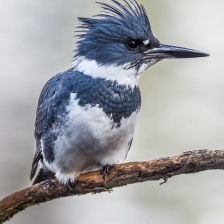

[('Belted Kingfisher', '99.993%'),
 ('Crested Nuthatch', '0.003%'),
 ('Downy Woodpecker', '0.003%')]

In [137]:
predict('test/BELTED KINGFISHER/1.jpg', model, sorted_list_of_dirs)

In [131]:
for pred_prob, pred_idx in zip(t.values.detach().numpy().flatten(), t.indices.detach().numpy().flatten()):
    predicted_label = sorted_list_of_dirs[pred_idx]
    predicted_prob = pred_prob*100
    print(f"Predicted label: {predicted_label}; Probability: {predicted_prob:4f}%")

Predicted label: Belted Kingfisher; Probability: 99.992526%
Predicted label: Crested Nuthatch; Probability: 0.003100%
Predicted label: Downy Woodpecker; Probability: 0.002712%
Predicted label: Black Throated Warbler; Probability: 0.000509%
Predicted label: Kookaburra; Probability: 0.000506%


In [129]:
t

torch.return_types.topk(
values=tensor([[9.9993e-01, 3.0996e-05, 2.7118e-05, 5.0902e-06, 5.0649e-06]],
       grad_fn=<TopkBackward>),
indices=tensor([[ 27,  68,  75,  32, 135]]))

In [38]:
#upload model file to s3:
s3 = boto3.client('s3')
s3.upload_file('trained_model_resnet50.pt', 'bird-classification-bucket', 'models/trained_model_resnet50.pt')

In [47]:
print(device)

cpu


In [140]:
train_loader.dataset

Dataset ImageFolder
    Number of datapoints: 35215
    Root location: train